### 1. Import libraries and formulate problems

In [1]:
import pulp
# from utils import *
import numpy as np
from carlo_monte_sampling import *
from collections import defaultdict
import matplotlib.pyplot as plt

In [2]:
def set_up_parameters(c,r,h_r,h_i,p,B,I_n,T_n,S):
    parameters={}
    parameters["c"]=c
    parameters["r"]=r
    parameters["h_r"]=h_r
    parameters["h_i"]=h_i
    parameters["p"]= p
    parameters["B"]=B
    parameters["I_n"]=I_n
    parameters["T_n"]=T_n
    parameters['S']=S
    
#     total_flows = {
#         "demand":0,"idle":0,"reposition":0
#     }
    
    return parameters

### 2. Upload file and Construct the Spatial-temporal Network G(N,A)

In [3]:
class create_network:
    def __init__(self):
        self.flow_MAT = {}
        self.demands={}
    
    def reset_MAT(self,parameters):
        I_n= parameters["I_n"]
        T_n= parameters["T_n"]
        supply_MAT = np.zeros((I_n,T_n))
        idles_MAT = np.zeros((I_n,T_n))
        self.flow_MAT["supply"] = supply_MAT
        self.flow_MAT["idles"] = idles_MAT

    def generate_random_demands(self,parameters,type_of_dist, average_trip,std):
        S= parameters["S"]
        I = parameters["I_n"]
        T= parameters["T_n"]
        self.demands = generate_samples(type_of_dist=type_of_dist, average_trip= average_trip,std =std,S=S,I=I,T=T)

# print(demand_arc)

### 3. Set up the Model

### 3.1 Set up and Solve the two-stage stochastic Problem 

In [4]:
def LP_stage_one(t_o,parameters,horizon,fulfill_rate,requests): 
    '''   
    inputs: t: time node 
            parameters: parameters
            fulfill_rate: the lowest fulfillment rate
            demand_ful: dictionary which stores the demand fulfillment arc
            horizon: number of time period is being considered in one horizon
    outputs: 
            cost:stage one cost
            a: supply at each location at time t = 0
            demand_ful: updated demand_ful
    '''   
    I_n = parameters["I_n"]
    T_n=parameters["T_n"]
    c = parameters["c"]
    r=parameters["r"]
    h_r= parameters["h_r"]
    h_i = parameters["h_i"]
    p = parameters["p"]
    B=parameters["B"]
    S=parameters["S"]
    t_end = min(t_o+horizon+1,T_n) #horizon number of time period
        
    #Set up the LP problem
    prob = pulp.LpProblem("Stage_One", pulp.LpMinimize)

    #Set up the variables      
    #variables include flow at idle arc, at relocation arc and supply at each node 
    fi_dict , fr_dict, x_dict,fd_dict = {},{},{},{} 
    #f_dict = {  s: { t:{name: pulp.variables } }  }  except for fd_dict and fr_dict = {s:{name:}}
    fd_obj= []    
    
    for s in range(1,S+1):
        fi_dict[s] , fr_dict[s], x_dict[s],fd_dict[s] = {},{},{},{}
        
        #fd (fulfilled demand flow): the flow on the arc should be no greater than the requests 
        #name convention: s_fd_t_t'_i_j
        for pair in requests[s]:
            name_fd = "s"+str(s)+"_fd_"+pair
            t_start,t_d, zone_start,zone_end = pair.split("_")
            request_flow = requests[s][pair]
            fd_dict[s][name_fd]= pulp.LpVariable(name=name_fd,lowBound = 0,upBound = request_flow,
                                              cat="Integer")  
            fd_obj.append(fd_dict[s][name_fd]*(int(t_d)-int(t_start)))

            
            #fr (reposition flow): The flow always take ONE time period and from zone i to zone j (i!=j)
            #name convention: s_fr_t_i_j
            if int(t_d)-int(t_start)==1:
                name_fr = "s"+str(s)+"_fr_"+pair
                fr_dict[s][name_fr]= pulp.LpVariable(name=name_fr,lowBound = 0,cat="Integer") 
                                                  
                    
        for t in range(t_o,t_end+1):          
            fi_dict[s][t], x_dict[s][t] = {},{}         
            for i in range(1,I_n+1):
                
                #fi (idle flow): the flow is always from i->i and t->t+1
                #name convention: s_fi_t_i 
                name_fi="s"+str(s)+"_fi_"+str(t)+"_"+str(i)
                fi_dict[s][t][name_fi]= pulp.LpVariable(name=name_fi,lowBound = 0,cat="Integer")
                                                                                                     
                #x (supply level): 
                #name convention: s_x_t_i
                name_x="s"+str(s)+"_x_"+str(t)+"_"+str(i)
                x_dict[s][t][name_x]=pulp.LpVariable(name=name_x,lowBound = 0,cat="Integer")                                 
                
                #Constraints
                    
                #C1: Flow balance at each node n_it               
                if t<t_end: #truncate at t_end
                    
                    #outbound:
                    prob+=(
                        #supply at n_i,t:
                        x_dict[s][t][name_x]

                        #idle flow from n_it:
                        -fi_dict[s][t][name_fi]

                        #demands flow from n_it:
                        -(pulp.lpSum(fd_dict[s][name] for name in fd_dict[s] 
                                     if name.split("_")[2] == str(t) and name.split("_")[4]==str(i))
                         )
                        
                        #reposition flow from n_it:
                        -(pulp.lpSum(fr_dict[s][name] for name in fr_dict[s] 
                                     if name.split("_")[2] == str(t) and name.split("_")[4]==str(i))
                         )
                    )==0
                    
                
                    #inbound:
                if t>t_o:
                    prob+= (
                        #supply at n_i,(t+1):
                        x_dict[s][t][name_x]
                        
                        #idle flow towards n_it:
                        -fi_dict[s][t-1]["s"+str(s)+"_fi_"+str(t-1)+"_"+str(i)]
                        
                        #demands flow toward n_it:
                        -(pulp.lpSum(fd_dict[s][name] for name in fd_dict[s] 
                                     if name.split("_")[3] == str(t) and name.split("_")[5]==str(i))
                         )
                        
                         #reposition flow toward n_it:
                        -(pulp.lpSum(fr_dict[s][name] for name in fr_dict[s] 
                                     if name.split("_")[3] == str(t) and name.split("_")[5]==str(i))
                         )                                    
                    
                    )==0
        
        #C2: TOTAL s_x_1_i from all scenarios share the same value (as s = 1)
        if s!=1:
            s1_name = "s"+str(1)+"_"+"x"+"_"+str(1)+"_"+str(i)
            prob+=pulp.lpSum(x_dict[s][1]) - pulp.lpSum(x_dict[1][1])==0       
            
        #C3: total actual fulfilled demands >= total fulfillment rate*requests
        if fulfill_rate:
            prob+= (pulp.lpSum(fd_dict[s]))-fulfill_rate*(pulp.lpSum(requests[s]))>=0
    
    Total_vehicle = pulp.lpSum(x_dict[t_o][1])
    idle_cost = h_i*pulp.lpSum(fi_dict)   
    reposition_cost = h_r*pulp.lpSum(fr_dict)
    revenue = r*pulp.lpSum(fd_obj)
    penalty=p*(pulp.lpSum(requests)-pulp.lpSum(fd_dict))
    
    prob+= (
        #stage-one cost: initialization
        c*Total_vehicle
        #expected stage-two cost
        +1/S*(idle_cost+reposition_cost+penalty-revenue)
    )
    
#     prob+= (
#         #stage-one cost: initialization
#         c*Total_vehicle
#         #expected stage-two cost
#         +1/S*(idle_cost+reposition_cost+penalty-revenue)
#     )<=B
           
    prob.solve()

    cache = {}
    cache["min_fulfilment_rate"]=fulfill_rate
    actual_rate=0
    cache["actual_rate_list"]= []
    for s in range(1,S+1):
        curr_rate = pulp.value(pulp.lpSum(fd_dict[s]))/pulp.value(pulp.lpSum(requests[s]))
        actual_rate+=curr_rate
        cache["actual_rate_list"].append(curr_rate)
    cache["actual_fulfilment_rate"] = 1/S*actual_rate
    cache["number_of_vehicles"]=pulp.value(Total_vehicle)
    cache["total_cost"]= pulp.value(prob.objective)
    cache["avg_cost_idle"]=pulp.value(1/S*h_i*pulp.lpSum(fi_dict))
    cache["avg_cost_reposition"]=pulp.value(1/S*h_i*pulp.lpSum(fi_dict))
    cache["avg_cost_revenue"]=pulp.value(1/S*revenue)
    cache["avg_penalty"]=pulp.value(1/S*penalty)
    
    return cache


### 3.2 Run the test

### 3.2.1 Set up variables
#### Variables:
    - depreciation value c per vehicle per day
    - positive impact r, revenue per time period per car
    - reposition cost h_r, cost per time period per car
    - idle cost h_i, cost per time period per car
    - p penalty if demand is not fulfilled per request
    - budget B per day,
    - Zone number I_n
    - Time period T, time point T_n
    - Number of scenarios: S
    


In [150]:
c=54
r = 10
h_r = 7
h_i = 2
B=5500
p = 0
I_n = 5
T_n = 12
S =100
parameters=set_up_parameters(c,r,h_r,h_i,p,B,I_n,T_n,S)

In [143]:
#### Generate random samples

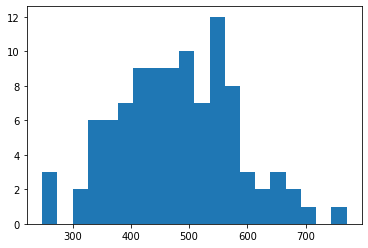

In [140]:

type_of_dist="normal"
graph = create_network()
graph.generate_random_demands(parameters=parameters,type_of_dist=type_of_dist, average_trip=500,std=100)
# print(graph.demands)

In [141]:
def driver(

    range_rate=[i for i in range(0,11)],
    parameters=parameters,
    requests = graph.demands
):
    cache_lst = [] #cache list for each fulfillment rate
    for fulfill_rate in range_rate:
        print(fulfill_rate/10)
        cache_lst.append(LP_stage_one(t_o=1,parameters=parameters,horizon = 10,fulfill_rate = 1/10*fulfill_rate,requests=requests))
    print("Done!")
    return cache_lst

In [151]:
def driver_price(
    r = [i for i in range(5,12)],
    requests = graph.demands
):
    cache_lst = [] #cache list for each unit flow cost 
    
#     parameters=set_up_parameters(c,r,h_r,h_i,p,B,I_n,T_n,S)
#     graph = create_network()
#     graph.generate_random_demands(parameters=parameters,type_of_dist=type_of_dist, average_trip=500,std=100)
    for i in r:
            print(i)
            parameters=set_up_parameters(c,i,h_r,h_i,p,B,I_n,T_n,S)
            cache_lst.append(LP_stage_one(t_o=1,parameters=parameters,horizon = 10,fulfill_rate = 0.8,requests=requests))
            
    return cache_lst

### 4. Results

**Case 1**: Relationship between the **actual fulfillment rate** and the **total number of vehicle**

In [144]:
def plot_results(cache_lst):

    fig, axs = plt.subplots(2, 2)
    fig.set_size_inches(20, 15)
    x0 = np.array([i for i in range(0,11)])
    x = np.array([round(cache["min_fulfilment_rate"], 3) for cache in cache_lst])
    y1 = np.array([round(min(cache["actual_rate_list"]), 3) for cache in cache_lst]) #Actual minimum fulfilment rate
    y_overall_rate = np.array([round(cache['actual_fulfilment_rate'],3) for cache in cache_lst])
    y2 = np.array([cache["number_of_vehicles"] for cache in cache_lst])
    y3= np.array([round(cache["total_cost"],0) for cache in cache_lst])
    
    
    width = 0.3
#     axs[0,0].bar(x0,x)
#     axs[0,0].bar(x0,y1)
    bar2=axs[0,0].bar(x0-width/2, y1, width=width, label="Actual minimum fulfilment")
    bar3= axs[0,0].bar(x0+width/2, y_overall_rate, width=width,label="Actual overall fulfilment rate for all scenarios")
    axs[0,0].set_title("Fullfilment Rate at different Minimum rate restraints",fontdict = {'fontname':'Comic Sans MS'})
    axs[0,0].set(ylabel="Fulfilment rate")
    axs[0,0].set(xlabel="Minimum fulfilment for all scenarios")

    axs[0,0].set_xticks(x0)
    axs[0,0].set_xticklabels(x)
    axs[0,0].legend()
    
    def autolabel_bar(rects):
        for rect in rects:
            height = rect.get_height()
            axs[0,0].annotate("{}".format(height),
                             xy = (rect.get_x()+rect.get_width()/2,height),
                             xytext=(0,3),
                             textcoords="offset points",
                             ha='center',va='bottom')
    autolabel_bar(bar2)  
    autolabel_bar(bar3) 
    
    def autolabel_plot(plot,x,y,n):
        for i in x0:
            plot.annotate("{}".format(y[i]),xy = (x[i],y[i]),xytext=(0,3),textcoords="offset points",
                             ha='center',va='bottom')  

    axs[0,1].plot(y_overall_rate,y2,'r^--',label = "Number of Vehicles")
    axs[0,1].set_title("Number of Vehicles at different actual average fulfilment rate",fontdict = {'fontname':'Comic Sans MS'})
    axs[0,1].set(xlabel="Actual Average fulfilment")
    axs[0,1].set(ylabel="Number of Vehicles")
    axs[0,1].legend()
    autolabel_plot(axs[0,1],y_overall_rate,y2,x0)
    
    axs[1,0].plot(y_overall_rate,y3,'b^--',label = "Total Cost")
    axs[1,0].set_title("Total cost at different actual average fulfilment rate",fontdict = {'fontname':'Comic Sans MS'})
    axs[1,0].set(xlabel="Actual Average fulfilment")
    axs[1,0].set(ylabel="Total daily cost")
    axs[1,0].legend()
    autolabel_plot(axs[1,0],y_overall_rate,y3,x0)
    
    axs[1,1].plot(y2,y3,'r.--',label = "Total cost")
    axs[1,1].set_title("Total cost at different number of initialized vechiles ",fontdict = {'fontname':'Comic Sans MS'})
    axs[1,1].set(xlabel="Total number of vehicles")
    axs[1,1].set(ylabel="Total daily cost")
    axs[1,1].legend()
    autolabel_plot(axs[1,1],y2,y3,x0)
        

    plt.show()


In [142]:
cache_normal= driver()

0.0
0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9
1.0
Done!


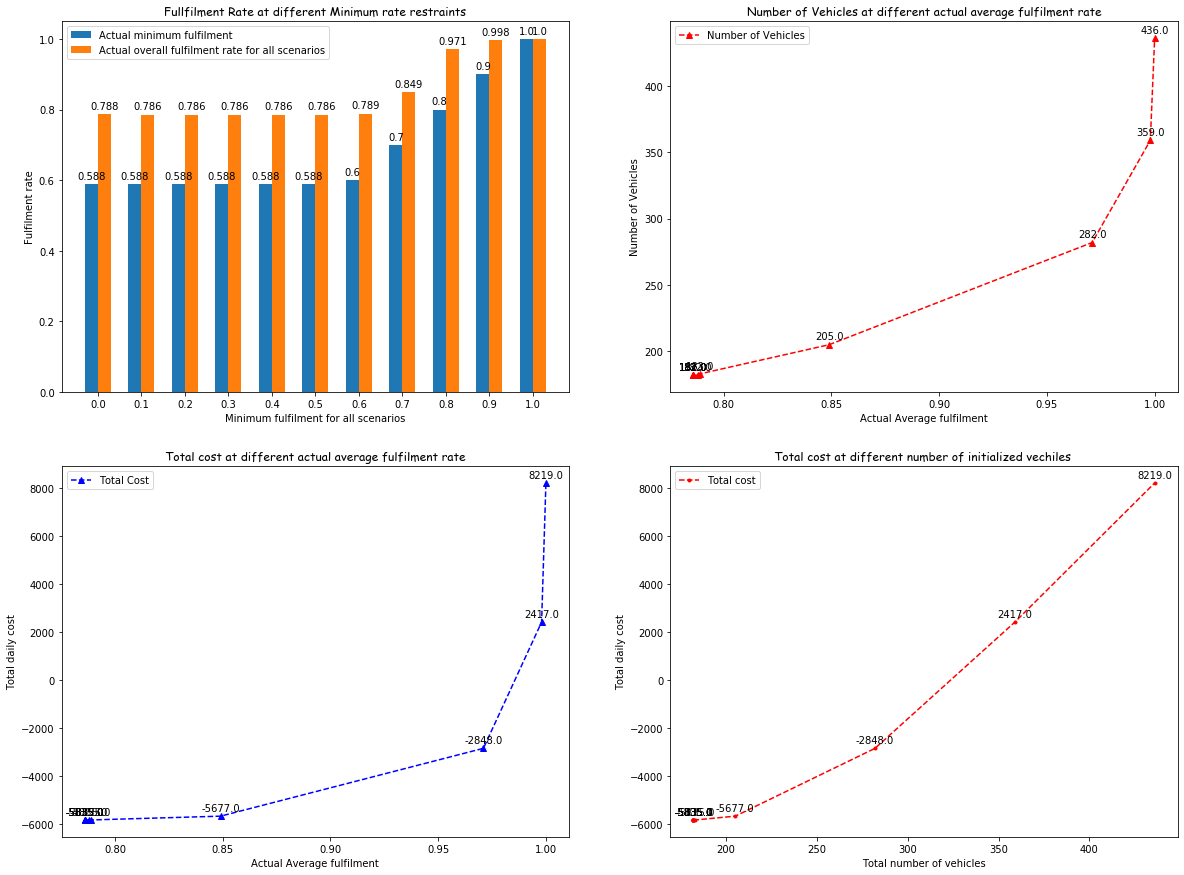

In [145]:
plot_results(cache_normal)

#### Optimal Cost vs Unit deman flow cost 

In [147]:
cache_price = driver_price()

5
6
7
8
9
10
11


In [168]:
def plot_results_price(cache_lst):

    fig, axs = plt.subplots()
    fig.set_size_inches(10, 8) 
    n = np.array([i for i in range(5,12)])
    x0=n
    y3= np.array([round(cache["total_cost"],0) for cache in cache_lst])
    
    def autolabel_plot(plot,x,y,n):
        for i in n:
            plot.annotate("{}".format(y[i]),xy = (x[i],y[i]),xytext=(0,3),textcoords="offset points",
                             ha='center',va='bottom')  


    
    axs.plot(x0,y3,'b^--',label = "Total Cost ($)")
    axs.set_title("Total cost at different unit cost for demand flow ($)",fontdict = {'fontname':'Comic Sans MS'})
    axs.set(xlabel="Unit cost for demand flow ($/hr)")
    axs.set(ylabel="Total daily cost ($/day)")
    axs.legend()
#     autolabel_plot(axs,x0,y3,n)

        

    plt.show()

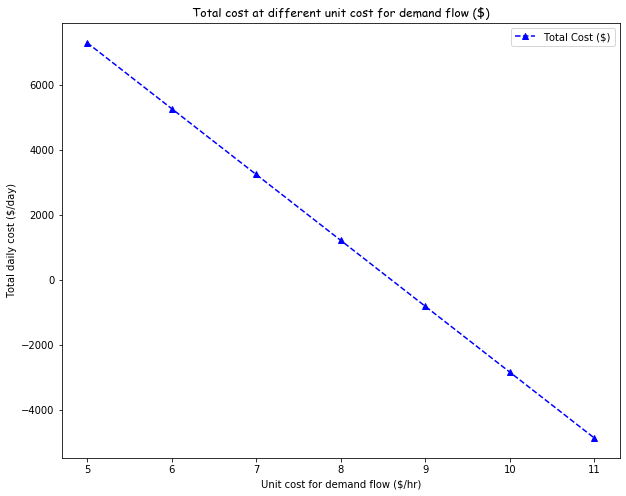

In [169]:
plot_results_price(cache_price)

In [152]:
cache_price_no_penalty = driver_price()

5
6
7
8
9
10
11


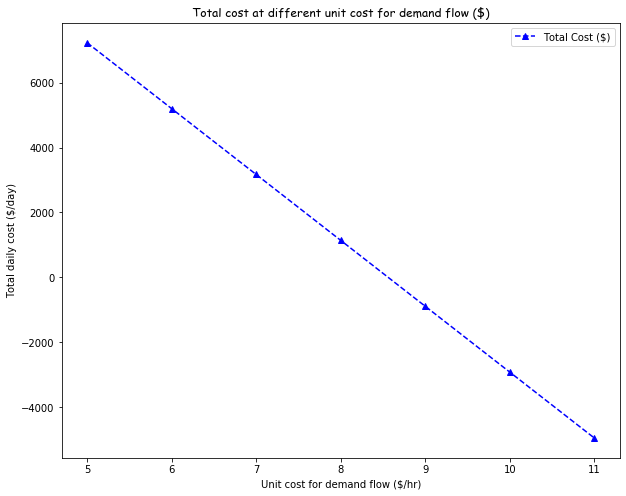

In [170]:
plot_results_price(cache_price_no_penalty)